In [1]:
import underworld.visualisation as vis

from underworld import function as fn
import underworld as uw

import matplotlib.pyplot as pyplot
import numpy as np
from scipy.spatial import distance

import math
import os
import sys

import time

from scipy.signal import savgol_filter

# deform the mesh geometry towards the ice-rock interface?
deform_mesh = False
perfect_mesh = True

In [2]:
# details of the bottom curve
# L = [160, 80, 40, 20, 10, 5]
L = 10
# make it command line compatible
if len(sys.argv):
    try:
        km_index = int(sys.argv[1])
    except:
        km_index = 5

maxX = L * 1000.
min_bed_height = 500.           # we want a minimum of 500 m of rock beneath the ice
omega = 2.0 * np.pi / maxX
amplitude = 500.
average_bedthickness = 1000.
surface_height = average_bedthickness + amplitude + min_bed_height
maxY = surface_height

minY = minX = 0.

g = 9.81
ice_density = 910.

A = 1e-16
n = 3.


resX = 64
resY = 32


print("resX: " + str(resX) + " resY: " + str(resY))

resX: 64 resY: 32


## generate output path

In [3]:

outputPath = os.path.join(os.path.abspath("."), "output_" + str(maxX) + "_res_" + str(resX) + "_x_" + str(resY) + "/")

if not os.path.exists(outputPath):
    os.makedirs(outputPath)

os.chdir(outputPath)

delta_timestep = 1.						# in years, used in the main loop
# after how many timesteps do we need new figures?
update_figures_after_n_timesteps = 1
number_of_deformation_lines = 11

number_of_deformation_points = 50000
distance_between_deformation_lines = maxY / (number_of_deformation_lines + 1)

cell_height = maxY / resY
cell_width = maxX / resX

## Mesh and mesh variables

In [4]:
elementType = "Q1/dQ0"
#elementType = "Q2/dQ1"
#elementType = "Q1/dPc1"
#elementType = "Q2/dPc1"

mesh = uw.mesh.FeMesh_Cartesian(elementType=(elementType),
                                elementRes=(resX, resY),
                                minCoord=(minX, minY),
                                maxCoord=(maxX, maxY),
                                periodic=[True, False])

submesh = mesh.subMesh

# save the mesh
# mesh.save(outputPath + "mesh.h5")

velocityField = uw.mesh.MeshVariable(mesh=mesh, nodeDofCount=mesh.dim)
#pressureField = uw.mesh.MeshVariable(mesh=mesh.subMesh, nodeDofCount=1)
pressureField = uw.mesh.MeshVariable(mesh=mesh, nodeDofCount=1)

viscosityField = uw.mesh.MeshVariable(mesh=mesh, nodeDofCount=1)

strainRateField = mesh.add_variable(nodeDofCount=1)

#pressureField.data[:] = 0.
velocityField.data[:] = [0., 0.]

# Initialise the 'materialVariable' data to represent different materials.
materialA = 0  	# accommodation layer, a.k.a. Sticky Air
materialV = 1  	# ice, isotropic
materialR = 2   # rock
materialT = 5   # test material in order to test eg interface detection

coord = fn.input()

z_bed_function = surface_height - average_bedthickness + amplitude * fn.math.sin(omega * coord[0])


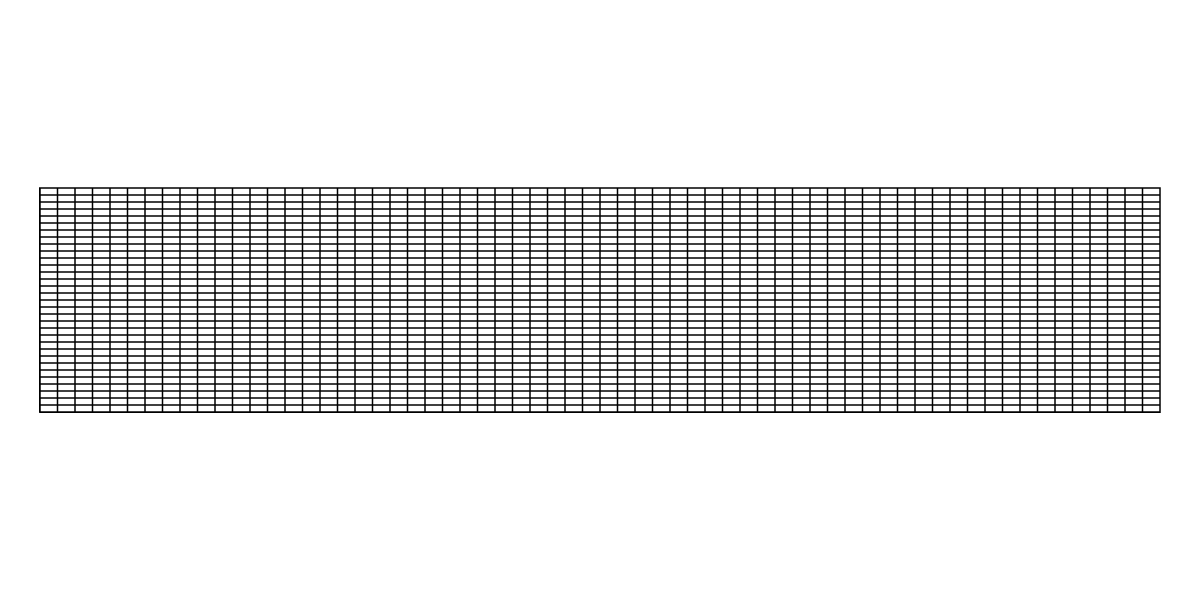

In [5]:
# # Define the ice-rock / ice-air interface 

botSet = mesh.specialSets['Bottom_VertexSet']
topSet = mesh.specialSets['Top_VertexSet']

dx = (maxX - minX) / resX
iceRockInterface = []
iceAirInterface = []

dx = (maxX - minX) / resX

for index in range(resX+1):
    
    start_x = dx * index

    interface_y =  surface_height - average_bedthickness + amplitude * np.sin(start_x * (np.pi * 2.) / (maxX-minX) )
                
    #ind = np.where(abs(mesh.data[:,0] - start_x) < 0.01*dx)
    iceRockInterface.append([start_x, interface_y])
    iceAirInterface.append([start_x, maxY])


# # Deform mesh to be almost structurally conforming

# In[15]:


def mesh_deform(section,fixPoint,mi):
    
    # fixPoint: the position to be refined
    # mi: representing the gradient of mesh resolution; the larger mi, the larger gradient
    # generally, mi ranges from 0.1 to 3, dependnig on the resolution 
 
    # note from Till: 
    # I normalize it, because then it becomes more clear to me.
    # normalization is not strictly necessary
    normalize = maxY - minY

    section /= normalize
    fixPoint /= normalize

    for index in range(len(section)):
        
        maxCoord = np.max(section)
        minCoord = np.min(section)
        
        if  section[index] < fixPoint:
            zz_sqrt = (fixPoint - section[index])**mi
            zz_sqrt_max = (fixPoint - minCoord)**mi
            section[index] = fixPoint - (fixPoint - section[index]) * zz_sqrt / zz_sqrt_max

        if  section[index] > fixPoint:
            zz_sqrt = (section[index] - fixPoint)**mi
            zz_sqrt_max = (maxCoord - fixPoint)**mi
            section[index] = fixPoint + (section[index] - fixPoint) * zz_sqrt/zz_sqrt_max        
    
    return (section * normalize)

dx = (maxX - minX) / resX


if deform_mesh:
    
    with mesh.deform_mesh():

        for index in range(resX+1):  

            start_x = dx * index

            interface_y =  surface_height - average_bedthickness + amplitude * np.sin(start_x * (np.pi * 2.) / (maxX-minX) )

            #print (start_x,interface_y)
            #lx.append(start_x)
            #ly.append(interface_y)

            #ind = np.where(abs(mesh.data[:,0] - start_x) < 0.01*dx)
            ind = np.where(abs(mesh.data[:,0] - start_x) < 0.01*dx)

            mesh.data[ind[0],1] = mesh_deform(mesh.data[ind[0],1], interface_y, 0.25)

# visualise the result
figMesh = vis.Figure(figsize=(1200,600))
figMesh.append( vis.objects.Mesh(mesh) )
figMesh.save_image("mesh_postdeform.png")
figMesh.show()

## Deform mesh to a perfect body fit mesh


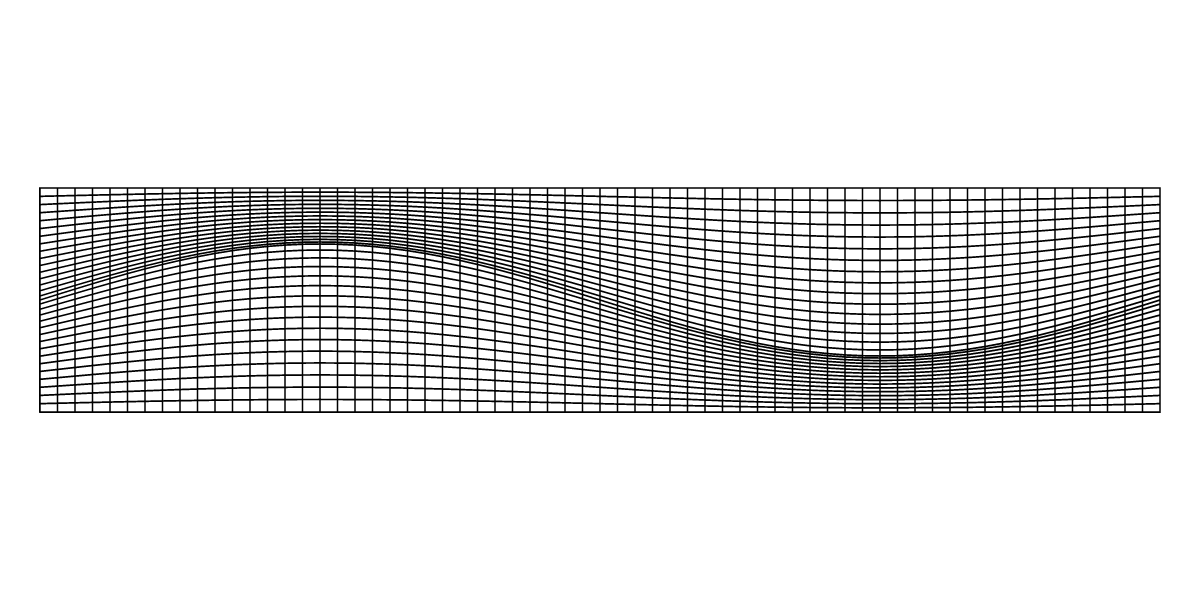

In [6]:
# visualise the result
def mesh_deform_Ind(section,fixPoint_index,fixPoint,mi):
    
    section[int(fixPoint_index)] = fixPoint
    seqN = len(section)
    
    # fixPoint_index (int): specify the index of the section to be at the place need to be refined
    # fixPoint: the position to be refined
    # mi: representing the gradient of mesh resolution; the larger mi, the larger gradient
    for index in range(len(section)):
        
        maxCoord = np.max(section)
        minCoord = np.min(section)
        
        if  index < fixPoint_index:
            section[index] = minCoord + index*(fixPoint-minCoord)/fixPoint_index            
            zz_sqrt = (fixPoint-section[index])**mi
            zz_sqrt_max = (fixPoint-minCoord)**mi
            section[index] = fixPoint-(fixPoint-section[index])*zz_sqrt/zz_sqrt_max

        if  index > fixPoint_index:
            section[index] = fixPoint + (index-fixPoint_index)*(maxCoord-fixPoint)/(seqN-fixPoint_index-1)
            zz_sqrt = (section[index]-fixPoint)**mi
            zz_sqrt_max = (maxCoord-fixPoint)**mi
            section[index] =fixPoint+(section[index]-fixPoint)*zz_sqrt/zz_sqrt_max    
            
    return (section)

if (perfect_mesh):
    
    with mesh.deform_mesh():
        
        for index in range(resX+1):  
            start_x = dx * index
            
            interface_y =  surface_height - average_bedthickness + amplitude * np.sin(start_x * (np.pi * 2.) / (maxX-minX) )
            
            ind = np.where(abs(mesh.data[:,0]-start_x)<0.01*dx)
            
            mesh.data[ind[0],1] = mesh_deform_Ind(mesh.data[ind[0],1],resY/2,interface_y,0.2)
    # make the swarm belong the element that is the same as the in the regular mesh
    
    # visualise the result
    figMesh = vis.Figure(figsize=(1200,600))
    figMesh.append( vis.objects.Mesh(mesh) )
    figMesh.save_image("mesh_deform_default_swarm.png")
    figMesh.show()

In [7]:
part_per_cell = 30
swarm = uw.swarm.Swarm(mesh=mesh, particleEscape=True)

#swarmLayout = uw.swarm.layouts.PerCellSpaceFillerLayout(swarm=swarm, particlesPerCell=part_per_cell)
swarmLayout = uw.swarm.layouts.PerCellGaussLayout( swarm=swarm, gaussPointCount=5 )

swarm.populate_using_layout(layout=swarmLayout)

measurementSwarm = uw.swarm.Swarm(mesh=mesh, particleEscape=True)

# create pop control object
pop_control1 = uw.swarm.PopulationControl(swarm, aggressive=True, particlesPerCell=part_per_cell)
pop_control2 = uw.swarm.PopulationControl(measurementSwarm)

# ### Create a particle advection system
#
# Note that we need to set up one advector systems for each particle swarm (our global swarm and a separate one if we add passive tracers).
advector1 = uw.systems.SwarmAdvector(swarm=swarm,velocityField=velocityField, order=2)
advector2 = uw.systems.SwarmAdvector(swarm=measurementSwarm,     velocityField=velocityField, order=2)


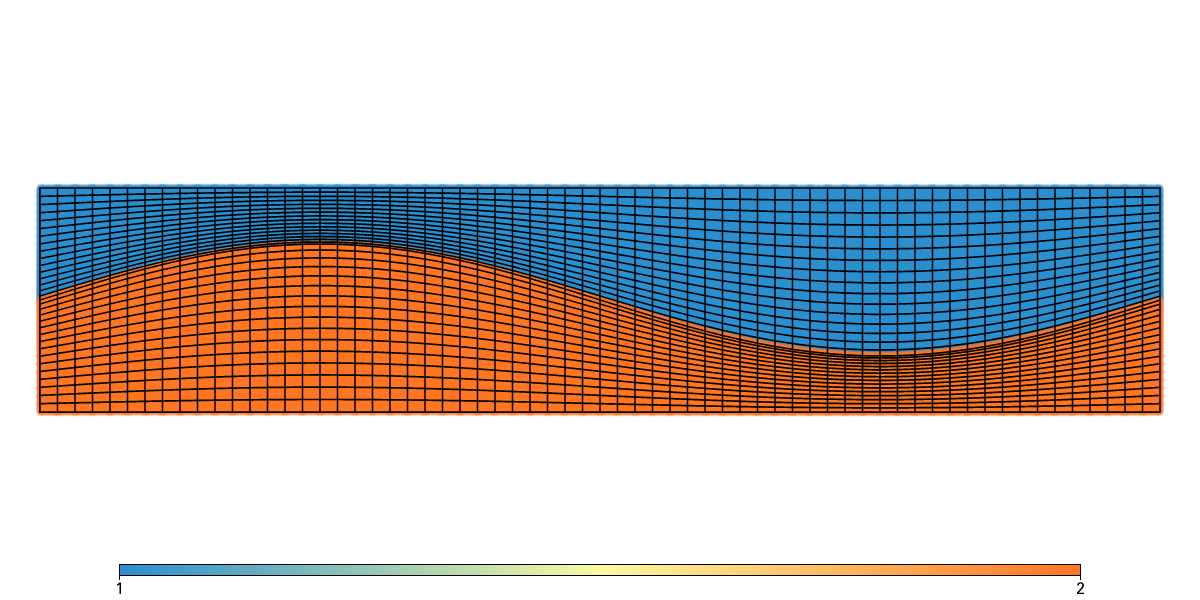

In [8]:
# Tracking different materials

materialVariable = swarm.add_variable(dataType="int", count=1)

numbMeasurementPoints = resX + 1
xloc = np.linspace(0, maxX, numbMeasurementPoints).reshape(-1,1)
yloc = (surface_height - average_bedthickness + amplitude * np.sin(omega * xloc)).reshape(-1,1)
xycoor = np.concatenate((xloc,yloc),axis = 1)

measurementSwarm.add_particles_with_coordinates(xycoor)

particleDensity = swarm.add_variable(dataType="double", count=1)
particleDensity.data[:] = 0.0

coord = fn.input()

conditions = [(coord[1] > surface_height, materialA),
              (coord[1] < z_bed_function, materialR),
              (True, materialV)]

materialVariable.data[:] = fn.branching.conditional(conditions).evaluate(swarm)

#pyplot.plot(measurementSwarm.data[:,0], measurementSwarm.data[:,1], color='black')

figMesh = vis.Figure(figsize=(1200,600))
figMesh.append( vis.objects.Mesh(mesh) )
figMesh.append( vis.objects.Points( swarm, materialVariable, pointSize=10.0 ) )
figMesh.save_image("mesh_deform.png")
figMesh.show()

## Model viscosity

In [9]:
strainRateTensor = fn.tensor.symmetric(velocityField.fn_gradient)
strainRate_2ndInvariantFn = fn.tensor.second_invariant(strainRateTensor)

minViscosityIceFn = fn.misc.constant(1e+10 / 3.1536e7)
maxViscosityIceFn = fn.misc.constant(1e+15 / 3.1536e7)

viscosityFnAir = fn.misc.constant(1e6 / 3.1536e7)
viscosityFnRock = fn.misc.constant(1e22 / 3.1536e7)

viscosityFnIceBase = 0.5 * A ** (-1./n) * (strainRate_2ndInvariantFn**((1.-n) / float(n)))
viscosityFnIce = fn.misc.max(fn.misc.min(viscosityFnIceBase, maxViscosityIceFn), minViscosityIceFn)

viscosityMap = {
                materialV: viscosityFnIce,
                materialA: viscosityFnAir,
                materialR: viscosityFnRock,
               }

viscosityFn = fn.branching.map( fn_key=materialVariable, mapping=viscosityMap )

logViscosityFn = fn.math.log10( fn.misc.max( fn.misc.min( viscosityFnIceBase, viscosityFnRock ), viscosityFnAir ) )

## Bouyance force 

In [10]:
devStressFn = 2.0 * viscosityFn * strainRateTensor
shearStressFn = strainRate_2ndInvariantFn * viscosityFn * 2.0

densityFnAir = fn.misc.constant( 0. )
densityFnIce = fn.misc.constant( ice_density )
densityFnRock = fn.misc.constant( 2700. )

densityMap = {
                materialA: densityFnAir,
                materialV: densityFnIce,
                materialR: densityFnRock
             }

densityFn = fn.branching.map(fn_key=materialVariable, mapping=densityMap)

particleDensity.data[:] = densityFn.evaluate(swarm)

surf_inclination = 0.5 * np.pi / 180. # 0.1 = Experiment D, 0.5 = Experiment B
#surf_inclination = 0.
z_hat = (math.sin(surf_inclination), - math.cos(surf_inclination))
#z_hat = (0.00872653549, -0.99996192306417128874)

buoyancyFn = densityFn * z_hat * 9.81

## Solver and boundary conditions

In [ ]:
iWalls = mesh.specialSets["MinI_VertexSet"] + mesh.specialSets["MaxI_VertexSet"]
jWalls = mesh.specialSets["MinJ_VertexSet"] + mesh.specialSets["MaxJ_VertexSet"]
base = mesh.specialSets["MinJ_VertexSet"]
top = mesh.specialSets["MaxJ_VertexSet"]

velocityField.data[:] = [0., 0.]

leftSet = mesh.specialSets['Left_VertexSet']
rightSet = mesh.specialSets['Right_VertexSet']

### Dirichlet
condition1 = uw.conditions.DirichletCondition(variable=velocityField,indexSetsPerDof=(botSet, botSet))

velocityField.data[:] = [0., 0.]

stokes = uw.systems.Stokes(
    velocityField=velocityField,
    pressureField=pressureField,
    voronoi_swarm=swarm,
    conditions=[
            condition1,
            ],
    fn_viscosity=viscosityFn,
    fn_bodyforce=buoyancyFn,
)

solver = uw.systems.Solver(stokes)

#solver.set_inner_method("lu")
#solver.set_inner_method("superlu")
solver.set_inner_method("mumps")
# solver.set_inner_method("superludist")
# solver.set_inner_method("mg")
#solver.set_inner_method("nomg")

# solver.set_penalty(1.0e10)  # higher penalty = larger stability
# solver.options.scr.ksp_rtol = 1.0e-3

In [ ]:
# nl_tol = 2.e1
nl_tol = 5.e-3

surfaceArea = uw.utils.Integral( fn=1.0, mesh=mesh, integrationType='surface', surfaceIndexSet=top)
surfacePressureIntegral = uw.utils.Integral( fn=pressureField, mesh=mesh, integrationType='surface', surfaceIndexSet=top)

def calibrate_pressure():

    global pressureField
    global surfaceArea
    global surfacePressureIntegral

    (area,) = surfaceArea.evaluate()
    (p0,) = surfacePressureIntegral.evaluate() 
    pressureField.data[:] -= p0 / area

    print (f'Calibration pressure {p0 / area}')

# test it out
try:
    exec_time = time.time()
    # solver.solve(nonLinearIterate=True, nonLinearTolerance=nl_tol, callback_post_solve=calibrate_pressure)
    solver.solve(nonLinearIterate=True, callback_post_solve=calibrate_pressure)
    # solver.solve(nonLinearIterate=True)
    exec_time = time.time() - exec_time

    # print time to a file
    with open('../time.txt', 'a') as f:
        f.write('length,' + str(maxX) + ',x_res:,' + str(resX) + ',y_res:,' + str(resY) + ',time in secs:,' + str(exec_time) + '\n')
        
    # print full stats to a file
    original_stdout = sys.stdout # Save a reference to the original standard output
    
    with open('../stats_' + "output_" + str(maxX) + "_res_" + str(resX) + '_x_' + str(resY) + '.txt', 'w') as f:
        sys.stdout = f # Change the standard output to the file we created.
        solver.print_stats()
        sys.stdout = original_stdout # Reset the standard output to its original value
        
    solver.print_stats()
except:
    print("Solver died early..")
    exit(0)


# # Output

# In[48]:

In [ ]:
meshStressTensor = uw.mesh.MeshVariable(mesh, 3 )
projectorStress = uw.utils.MeshVariable_Projection( meshStressTensor, devStressFn, type=0 )
projectorStress.solve()

## correct the pressure
meshCorrectedPressure = uw.mesh.MeshVariable(mesh, 1 )
meshSecondCorrectedPressure = mesh.add_variable( 1 )

## a) from the pressureField
meshCorrectedPress = uw.utils.MeshVariable_Projection( meshCorrectedPressure, pressureField, type=0 )
meshCorrectedPress.solve()

## b) from the stranirate tensor
pressureFn = (strainRateTensor[0] + strainRateTensor[1]) * viscosityFn
meshSecondCorrectedPress = uw.utils.MeshVariable_Projection( meshSecondCorrectedPressure, pressureFn, type=1 )
meshSecondCorrectedPress.solve()

## shear stress as saved to disk
shearStressFn = 2.0 * viscosityFn * strainRateTensor[2]
meshShearStress = mesh.add_variable( 1 )

projectorStress = uw.utils.MeshVariable_Projection( meshShearStress, shearStressFn, type=0 )
projectorStress.solve()

## second invariant of stress as saved to disk
secInvStressFn = 2.0 * viscosityFn * strainRate_2ndInvariantFn
secInvStress = mesh.add_variable( 1 )

projectorStress = uw.utils.MeshVariable_Projection( secInvStress, secInvStressFn, type=0 )
projectorStress.solve()

# save to disc
outputFile = os.path.join(os.path.abspath("."), outputPath + "output_" + str(maxX) + ".csv")

####

x = np.linspace(0, maxX, resX+1)
interfacex = [item[0] for item in iceRockInterface]
interfacey = [item[1] for item in iceRockInterface]

airinterfacey = [maxY for item in range(resX + 1)]

iceRockInterface = np.array(iceRockInterface)
iceAirInterface = np.array(iceAirInterface)

add = 1. * cell_height
sub = - 1. * cell_height

#add = 5.
#sub = - 5.

###

shearstress_xy_above = []
corr_shearstress_xy_above = []
shearstress_xy_below = []
corr_shearstress_xy_below = []

for i,j in zip(interfacex,interfacey):
    
    shearstress_xy_above.append(shearStressFn.evaluate((i,j + add))[0][0])
    corr_shearstress_xy_above.append(meshStressTensor.evaluate((i,j + add))[0][2])
    
    shearstress_xy_below.append(shearStressFn.evaluate((i,j + sub))[0][0])
    corr_shearstress_xy_below.append(meshStressTensor.evaluate((i,j + sub))[0][2])
    
secinvstress_above = []
corr_secinvstress_above = []
secinvstress_below = []
corr_secinvstress_below = []

for i,j in zip(interfacex,interfacey):
    
    secinvstress_above.append(secInvStressFn.evaluate((i,j + add))[0][0])
    corr_secinvstress_above.append(secInvStress.evaluate((i,j + add))[0][0])
    
    secinvstress_below.append(secInvStressFn.evaluate((i,j + sub))[0][0])
    corr_secinvstress_below.append(secInvStress.evaluate((i,j + sub))[0][0])
    
####

pressure = []
corr_pressure = []
for i,j in zip(interfacex,interfacey):
    pressure.append(pressureField.evaluate((i, j + add))[0][0])
    corr_pressure.append(meshCorrectedPressure.evaluate((i, j + add))[0][0])
    
with open(outputFile, "w") as text_file:

    text_file.write("X," + "Y," + "surf vx," + "surf vy," +                     "tauxy integr. above," + "tauxy dir. above," +                     "secinvare integr. above," + "secinvar dir. above," +                     "tauxy integr. below," + "tauxy dir. below," +                     "secinvare integr. below," + "secinvar dir. below," +                     "P integr.," + "P dir.," + "\n")
    
    for i in range(0,len(interfacex)):

        textline =         str(interfacex[i]) + ","         + str(interfacey[i]) + ","                 + str(velocityField.evaluate((interfacex[i], airinterfacey[i]))[0][0]) + ","         + str(velocityField.evaluate((interfacex[i], airinterfacey[i]))[0][1]) + ","                 + str(corr_shearstress_xy_above[i]) + ","         + str(shearstress_xy_above[i]) + ","         + str(corr_secinvstress_above[i]) + ","         + str(secinvstress_above[i]) + ","                 + str(corr_shearstress_xy_below[i]) + ","         + str(shearstress_xy_below[i]) + ","         + str(corr_secinvstress_below[i]) + ","         + str(secinvstress_below[i]) + ","                 + str(corr_pressure[i]) + ","         + str(pressure[i]) +         "\n"
        
        text_file.write(textline)

# In[116]:

# plot saved files

outputFile = outputPath + "output_" + str(maxX) + ".csv"
a = np.loadtxt(open(outputFile, "rb"), delimiter=",", skiprows=1)
a = a.T

print ("topo")
pyplot.scatter (a[0], a[1])
yhat = savgol_filter(a[1], 13, 7)
pyplot.plot(a[0], yhat, color='red')
pyplot.show()
pyplot.savefig("topo.png")

print ("top x vel")
pyplot.scatter (a[0], a[2])
yhat = savgol_filter(a[2], 13, 7)
pyplot.plot(a[0], yhat, color='red')
pyplot.show()
pyplot.savefig("top x vel.png")

print ("top y vel")
pyplot.scatter (a[0], a[3])
yhat = savgol_filter(a[3], 13, 9)
pyplot.plot(a[0], yhat, color='red')
pyplot.show()
pyplot.savefig("top y vel.png")

print ("top total vel")
pyplot.scatter (a[0], np.sqrt(a[3]**2 + a[2]**2))
yhat = savgol_filter(np.sqrt(a[3]**2 + a[2]**2), 13, 5)
pyplot.plot(a[0], yhat, color='red')
pyplot.show()
pyplot.savefig("top total vel.png")

print ("tau integr. above")
pyplot.scatter (a[0], a[4])
yhat = savgol_filter(a[4], 13, 4)
pyplot.plot(a[0], yhat, color='red')
pyplot.show()
pyplot.savefig("tau integr. above.png")

print ("tau integr. below")
pyplot.scatter (a[0], a[8])
yhat = savgol_filter(a[8], 13, 4)
pyplot.plot(a[0], yhat, color='red')
pyplot.show()
pyplot.savefig("tau integr. below.png")

print ("tau dir. above")
pyplot.scatter (a[0], a[5])
yhat = savgol_filter(a[5], 13, 5)
pyplot.plot(a[0], yhat, color='red')
pyplot.show()
pyplot.savefig("tau dir. above.png")

print ("tau dir. below")
pyplot.scatter (a[0], a[9])
yhat = savgol_filter(a[9], 13, 5)
pyplot.plot(a[0], yhat, color='red')
pyplot.show()
pyplot.savefig("tau dir. below.png")

print ("sec inv integr. above")
pyplot.scatter (a[0], a[6])
yhat = savgol_filter(a[6], 13, 5)
pyplot.plot(a[0], yhat, color='red')
pyplot.show()
pyplot.savefig("sec inv integr. above.png")

print ("sec inv integr. below")
pyplot.scatter (a[0], a[10])
yhat = savgol_filter(a[10], 13, 5)
pyplot.plot(a[0], yhat, color='red')
pyplot.show()
pyplot.savefig("sec inv integr. below.png")

print ("sec inv dir. above")
pyplot.scatter (a[0], a[7])
yhat = savgol_filter(a[7], 13, 5)
pyplot.plot(a[0], yhat, color='red')
pyplot.show()
pyplot.savefig("sec inv dir. above.png")

print ("sec inv dir. below")
pyplot.scatter (a[0], a[11])
yhat = savgol_filter(a[11], 13, 5)
pyplot.plot(a[0], yhat, color='red')
pyplot.show()
pyplot.savefig("sec inv dir. below.png")

print ("basal pressure integr.")
pyplot.scatter (a[0], a[12])
yhat = savgol_filter(a[12], 13, 5)
pyplot.plot(a[0], yhat, color='red')
pyplot.show()
pyplot.savefig("basal pressure integr.png")

print ("basal pressure dir.")
pyplot.scatter (a[0], a[13])
yhat = savgol_filter(a[13], 13, 5)
pyplot.plot(a[0], yhat, color='red')
pyplot.show()
pyplot.savefig("basal pressure dir.png")


# In[ ]:


# plot figures

figinflow = vis.Figure(figsize=(1800,500), title="free slip with in/out flow")
figinflow.append(vis.objects.VectorArrows(mesh, velocityField))
figinflow.append(vis.objects.Surface(mesh, uw.function.math.dot(velocityField,velocityField), colours="gebco"))
figinflow.save_image(outputPath + "velocity_" + str(maxX) + ".png")
figinflow.show()

figMaterial = vis.Figure(figsize=(1800, 500), title="Material")
figMaterial.append(vis.objects.Points( swarm, materialVariable, pointSize=1.0))
figMaterial.append( vis.objects.Mesh(mesh) )
figMaterial.save_image(outputPath + "material_" + str(maxX) + ".png")
figMaterial.show()

figDensity = vis.Figure(figsize=(1800, 500), title="Density")
figDensity.append(vis.objects.Points( swarm, particleDensity, pointSize=1.0))
figDensity.save_image(outputPath + "density_" + str(maxX) + ".png")
figDensity.show()

figViscosity = vis.Figure(figsize=(1800, 500), title="viscosity")
figViscosity.append(vis.objects.Surface(mesh, logViscosityFn))
figViscosity.save_image(outputPath + "logviscosity_" + str(maxX) + ".png")
figViscosity.show()

figPressure = vis.Figure(figsize=(1800, 500), title="pressure")
figPressure.append(vis.objects.Surface(mesh, pressureField))
figPressure.save_image(outputPath + "pressure_" + str(maxX) + ".png")
figPressure.show()

figShearStress = vis.Figure(figsize=(1800, 500), title="corr_shearstress_xy")
figShearStress.append(vis.objects.Surface(mesh, meshShearStress))
figShearStress.save_image(outputPath + "corr_shearstress_xy" + str(maxX) + ".png")
figShearStress.show()


## finally save meshvars, swarmvars, xdmf vars

In [ ]:
# In[ ]:


xdmf_info_mesh    = mesh.save('mesh.h5')
xdmf_info_meshVelocityField = velocityField.save('meshVelocityField.h5')
xdmf_info_meshShearStress = meshShearStress.save('meshShearStress.h5')
xdmf_info_meshCorrectedPressure = meshCorrectedPressure.save('meshCorrectedPressure.h5')

# swarm
xdmf_info_swarm    = swarm.save('swarm.h5')
xdmf_info_swarmMaterialVariable = materialVariable.save('swarmMaterialVariable.h5')

# xdmf mesh
velocityField.xdmf('meshVelocityField.xdmf', xdmf_info_meshVelocityField, "velocityField", xdmf_info_mesh, "TheMesh", modeltime=0.0)
meshShearStress.xdmf('meshShearStress.xdmf', xdmf_info_meshShearStress, "meshShearStress", xdmf_info_mesh, "TheMesh", modeltime=0.0)
meshCorrectedPressure.xdmf('meshCorrectedPressure.xdmf', xdmf_info_meshCorrectedPressure, "correctedPressureField", xdmf_info_mesh, "TheMesh", modeltime=0.0)

# xdmf swarm
materialVariable.xdmf('swarmMaterialVariable.xdmf', xdmf_info_swarmMaterialVariable, "material", xdmf_info_swarm, "TheSwarm", modeltime=0.0)


# In[ ]: